<a href="https://colab.research.google.com/github/snaiws/NLP_project/blob/koelectra%2Fsecond/STS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Textual Similarity for Korean



## Import

### Libraries, random seed, directory

In [1]:
from IPython.display import clear_output
!pip install transformers
!pip install optuna
!pip install diagrams
clear_output()

In [2]:
import os
import sys
import re
import pandas as pd
import numpy as np 
import copy
import time
import random
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,  RandomSampler, SequentialSampler, random_split
from torch.nn.utils import clip_grad_norm_

from transformers import ElectraTokenizer
from transformers import BertTokenizer
import transformers
from transformers import AdamW, get_scheduler

from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import pearsonr

import optuna

from diagrams import Cluster, Diagram
from diagrams.programming.flowchart import InputOutput
from diagrams.gcp.compute import Functions


In [3]:
# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB
cuda


In [4]:
# seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# mounting google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# git clone directory
cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:
# git clone
!git clone https://github.com/snaiws/NLP_project

Cloning into 'NLP_project'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 399 (delta 145), reused 124 (delta 72), pack-reused 143
Receiving objects: 100% (399/399), 9.52 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [8]:
# work directory
cd /content/drive/MyDrive/NLP_project

/content/drive/MyDrive/NLP_project


### Model, Tokenizer

In [9]:
# custom models
print(os.listdir('/content/drive/MyDrive/NLP_project/CustomModels'))

['BERT_baseline.py', 'BERT_seq.py', 'RoBERTa_large.py', 'koelectra_second.py']


In [10]:
# importing a custom model
from CustomModels.koelectra_second import koelectra_second

In [11]:
# init tokenizer and custom model
#tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-small")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-base")
#tokenizer = BertTokenizer.from_pretrained("klue/roberta-large")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator", do_lower_case=False)
customModel = koelectra_second(hidden_size=768, n_label=6)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Given data

In [12]:
# loading data
df_train0 = pd.read_json('./data/klue-sts-v1.1_train.json')
df_test0 = pd.read_json('./data/klue-sts-v1.1_dev.json')

In [13]:
# shape
df_train0.shape, df_test0.shape

((11668, 6), (519, 6))

### Collected data

### target balence

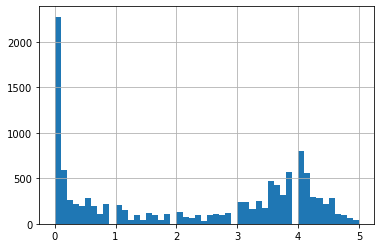

In [24]:
# real label histogram
df_train0['labels'].map(lambda x: x['real-label']).hist(bins=50)

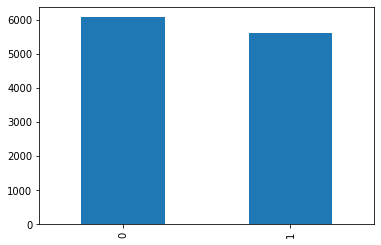

In [25]:
# binary label bar plot
df_train0['labels'].map(lambda x: x['binary-label']).value_counts().plot(kind='bar')

### duplicates

In [14]:
# train duplicates
df_train0[df_train0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations
1514,klue-sts-v1_train_01514,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
1661,klue-sts-v1_train_01661,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
1715,klue-sts-v1_train_01715,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
3872,klue-sts-v1_train_03872,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."
5139,klue-sts-v1_train_05139,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
5292,klue-sts-v1_train_05292,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
7045,klue-sts-v1_train_07045,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10908,klue-sts-v1_train_10908,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10939,klue-sts-v1_train_10939,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
11112,klue-sts-v1_train_11112,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."


In [15]:
# test duplicates
df_test0[df_test0.duplicated(['sentence1','sentence2'],keep=False)==True]

,guid,source,sentence1,sentence2,labels,annotations


In [16]:
# checking data leakage
pd.concat([df_train0.drop_duplicates(['sentence1','sentence2']),df_test0]).duplicated(['sentence1','sentence2']).sum()

0

In [17]:
# nulls
df_train0.isna().sum().sum()+df_test0.isna().sum().sum()

0

## Data preprocess

### Preprocess

In [18]:
def check_st(text):
  '''
  This regax function remove all except Korean and numbers
  '''
  text = re.sub(r"[^ㄱ-힣0-9\s]","",text)
  return text

def base_preprocess(train, test):
    '''
    For train and test data,
    This function use regax and drop duplicates.
    and arrange feature, target for different models
    '''
    train = train.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)
    s1 = train['sentence1'].map(lambda x: check_st(x))
    s2 = train['sentence2'].map(lambda x: check_st(x))
    cls = train['labels'].map(lambda x: int(x['real-label']))
    reg = train['labels'].map(lambda x: x['real-label'])
    binary1 = train['labels'].map(lambda x: int(x['binary-label']))
    binary2 = train['labels'].map(lambda x: int(x['binary-label']))
    binary2.replace(0,-1,inplace=True)
    train = pd.concat([s1,s2,reg,cls,binary1,binary2],axis=1)
    train.columns = ['sentence1','sentence2','reg','cls','binary1','binary2']
    train['sentence'] = train.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)

    s1 = test['sentence1'].map(lambda x: check_st(x))
    s2 = test['sentence2'].map(lambda x: check_st(x))
    cls = test['labels'].map(lambda x: int(x['real-label']))
    reg = test['labels'].map(lambda x: x['real-label'])
    binary1 = test['labels'].map(lambda x: int(x['binary-label']))
    binary2 = test['labels'].map(lambda x: int(x['binary-label']))
    binary2.replace(0,-1,inplace=True)
    test = pd.concat([s1,s2,reg,cls,binary1,binary2],axis=1)
    test.columns = ['sentence1','sentence2','reg','cls','binary1','binary2']
    test['sentence'] = test.apply(lambda x: x['sentence1']+' [SEP] '+x['sentence2'],axis=1)
    return train, test

In [19]:
df_train, df_test = base_preprocess(df_train0,df_test0)

In [20]:
df_train.head()

,sentence1,sentence2,reg,cls,binary1,binary2,sentence
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3.714286,3,1,1,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다 [SEP] 숙박시설의 위치...
1,위반행위 조사 등을 거부방해기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다,0.000000,0,0,-1,위반행위 조사 등을 거부방해기피한 자는 500만원 이하 과태료 부과 대상이다 [SE...
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333,0,0,-1,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘 [SEP] 사...
3,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업성공...,고용보험이 1차 고용안전망이라면 국민취업지원제도는 2차 고용안전망입니다,0.571429,0,0,-1,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업성공...
4,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다,4.714286,4,1,1,호스트의 답장이 늦으나 개선될 것으로 보입니다 [SEP] 호스트 응답이 늦었지만 개...


### Augmentation

### Token length

In [33]:
def tknz(text):
    '''
    temporal tokenizer function
    '''
    x = tokenizer(
            text,
            add_special_tokens=True,
            truncation=True, 
            max_length=512,
            return_tensors='pt'
        )
    return x

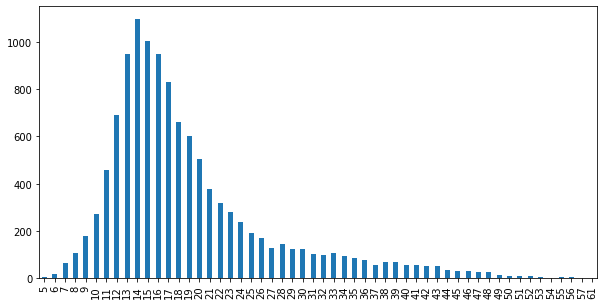

In [34]:
# token length of feature sentence1, tokenized by selected tokenizer
df_train['sentence1'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(10,5))

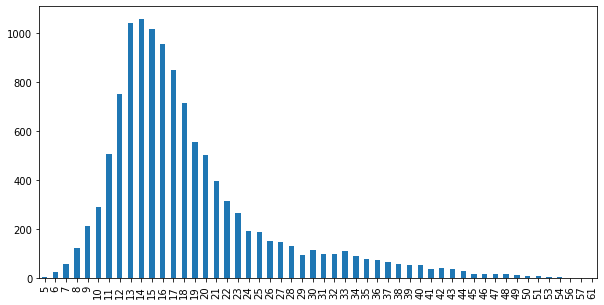

In [35]:
# token length of feature sentence2, tokenized by selected tokenizer
df_train['sentence2'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(10,5))

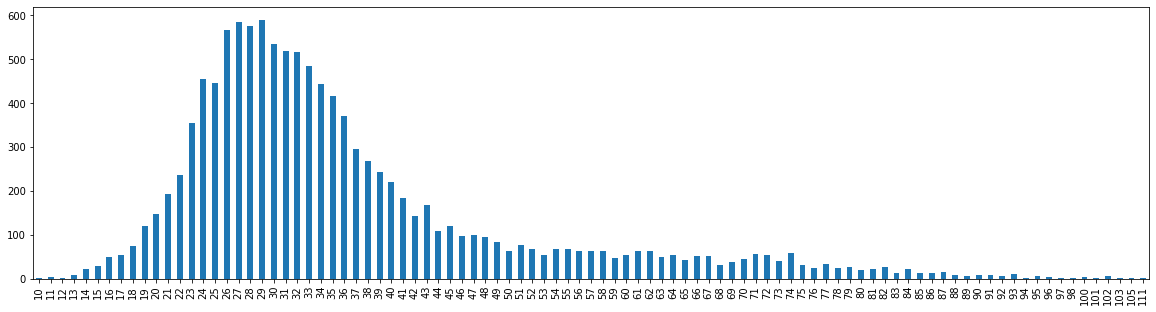

In [36]:
# token length of sentence1 + [SEP] + sentence2, tokenized by selected tokenizer
df_train['sentence'].map(lambda x: tknz(x).input_ids.shape[1]).value_counts().sort_index().plot(kind='bar',figsize=(20,5))

### Dataset

In [21]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [22]:
train_dataset = CustomDataset(df_train.sentence.to_list(), df_train.cls.to_list())
test_dataset = CustomDataset(df_test.sentence.to_list(), df_test.cls.to_list())

### Split Data

In [23]:
# split data
n_sample = df_train.shape[0] 
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid],generator=torch.Generator().manual_seed(seed))

In [24]:
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Valid Dataset len: {len(valid_dataset)}")
print(f"Test Dataset len: {len(test_dataset)}")

Train Dataset len: 10494
Valid Dataset len: 1167
Test Dataset len: 519


## Utils

### Data Loader

In [25]:
# Custom collate_fn 
def koelectra_collate_fn(batch):
    """
    For each batches, this function tokenize sentence and convert it to tensor
    applying dynamic padding 
    also convert target to tensor
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input_list,
        add_special_tokens=True,
        padding="longest", 
        truncation=True, 
        max_length=512,
        return_tensors='pt' 
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [26]:
def init_data_loader(train_dataset,valid_dataset,test_dataset, train_batch_size, eval_batch_size):
    '''
    This function make data generator for model input.
    input(dataset) - batch - sampler - custom collate function - output(a batch of tokenized data/label tensor)
    '''
    train_dataloader = DataLoader(
        train_dataset,
        batch_size = train_batch_size,
        sampler = RandomSampler(train_dataset,generator=torch.Generator().manual_seed(seed)),
        collate_fn = koelectra_collate_fn
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size = eval_batch_size,
        sampler = SequentialSampler(valid_dataset),
        collate_fn = koelectra_collate_fn
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size = eval_batch_size,
        sampler = SequentialSampler(test_dataset),
        collate_fn = koelectra_collate_fn
    )
    print(f"Train dataloader # steps: {len(train_dataloader)}")
    print(f"Valid dataloader # steps: {len(valid_dataloader)}")
    print(f"Test dataloader # steps: {len(test_dataloader)}")
    return train_dataloader, valid_dataloader, test_dataloader

### Initializer

In [27]:
def initializer(model, train_dataloader, scheduler, warmup, lr, epochs, weight_decay):
    '''
    This function initializes model, optimizer, scheduler
    '''
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")
    # initialize model 
    model = copy.deepcopy(model)
    # initilize optimizer 
    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=lr,
        eps=1e-8,
        weight_decay=weight_decay
    )
    # initilize scheduler
    scheduler = get_scheduler(
        scheduler,
        optimizer, 
        num_warmup_steps = warmup, 
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

### Early stopping

In [28]:
class EarlyStopping:
    """
    Stop training when validation loss doesn't get better after some 'patience'
    save checkpoint of best epoch
    """
    def __init__(self, patience=1, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.path.abspath(os.curdir)

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, epoch, loss):
        file_name = f'{self.path}/model.ckpt.best'
        
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss' : loss
            }, 
            file_name
        )
      
        print(f"Saving epoch {epoch} checkpoint at {file_name}")

### Train

In [29]:
def train_model(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, epochs, loss_fn):
    '''
    this 
    '''
    early_stopping = EarlyStopping(patience = patience, verbose = True) # initialize early_stopping
    vis2 = [] # list for visualizing
    # epoch
    for epoch in range(1, epochs + 1):
        print(f"*****Epoch {epoch} Train Start*****")
        
        total_loss, batch_loss, batch_count = 0,0,0 # variables for print avg loss per batch and total average loss

        vis1 = [] # list for visualizing train loss and learning rate for each batch

        model.train() # training mode
        model.to(device) # allocate device

        # batch
        for step, batch in enumerate(train_dataloader): # data generator
            batch_count+=1
            
            batch = tuple(item.to(device) for item in batch) # allocate device
        
            batch_input, batch_label = batch
            model.zero_grad() # initialize prior gradient
        
            # forward
            logits = model(**batch_input)
            # loss
            loss = loss_fn(logits, batch_label)
            batch_loss += loss.item()
            total_loss += loss.item()
            vis1.append([loss.item(), optimizer.param_groups[0]['lr']]) # get loss for visualization

            # backward propagation
            loss.backward() 
            
            # gradient clipping
            clip_grad_norm_(model.parameters(), threshold)
            
            # update optimizer & scheduler
            optimizer.step()
            scheduler.step()

            # print avg loss and learning rate for every 10 batches
            if (step % 10 == 0 and step != 0):
                learning_rate = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch}, Batch : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                # reset 
                batch_loss, batch_count = 0,0
        
        print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
        print(f"*****Epoch {epoch} Train Finish*****\n")
        
        vis1 = pd.DataFrame(vis1,columns=['Train loss','Learning rate'])
        vis1.plot(kind='line',subplots=True, xlabel='batch',figsize=(20,10), title=f'epoch {epoch}')

        # validation
        print(f"*****Epoch {epoch} Valid Start*****")
        valid_loss, valid_acc = validate(model, valid_dataloader, loss_fn)
        print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
        print(f"*****Epoch {epoch} Valid Finish*****\n")

        vis2.append([total_loss/(step+1),valid_loss])

        # early_stopping
        early_stopping(valid_loss, model, optimizer, scheduler, epoch)
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    viz2 = pd.DataFrame(vis2,columns=['train loss','valid loss'])
    viz2.plot(kind='line', xlabel='epoch',figsize=(20,10))
            
    print("Train Completed. End Program.")

### Validate

In [30]:
def validate(model, valid_dataloader, loss_fn):
    '''
    This function validate model
    '''
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # no calculation for gradient
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fn(logits, batch_label)
        total_loss += loss.item()
        
        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc
    

## Train

In [31]:
# argument setting
train_batch_size = 32
eval_batch_size = 64
epochs = 25
patience = 2 # early stopping patience
lr = 2e-5 # learning rate
# schedulers : ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup']
scheduler_name = 'cosine'
warmup = 200 # scheduler's warmup unit is batch(step)
threshold = 1 # gradient clipping threshold
weight_decay = 0.01 # 0~0.1 logscale

loss_fn = nn.CrossEntropyLoss()
'''
loss functions
-- Binary classification --
nn.BCELoss
nn.BCEWithLogitsLoss
nn.SoftMarginLoss
nn.HingeEmbeddingLoss # 1 or -1
nn.CosineEmbeddingLoss # 1 or -1

-- 3 inputs --
nn.TripletMarginLoss
nn.TripletMarginWithDistanceLoss

-- Regession --
nn.L1Loss
nn.SmoothL1Loss
nn.MSELoss
nn.HuberLoss

-- order --
nn.MarginRankingLoss

-- distance --
nn.CosineSimilarity
nn.PairwiseDistance

-- multi class classification --
nn.CrossEntropyLoss # log softmax 포함
nn.KLDivLoss(reduction='batchmean') #log softmax 포함
nn.MultiLabelMarginLoss
nn.MultiLabelSoftMarginLoss
nn.MultiMarginLoss

-- continuous input --
nn.NLLLoss # softmax 없음
nn.PoissonNLLLoss
nn.GaussianNLLLoss

-- time series --
nn.CTCLoss
'''

"\nloss functions\n-- Binary classification --\nnn.BCELoss\nnn.BCEWithLogitsLoss\nnn.SoftMarginLoss\nnn.HingeEmbeddingLoss # 1 or -1\nnn.CosineEmbeddingLoss # 1 or -1\n\n-- 3 inputs --\nnn.TripletMarginLoss\nnn.TripletMarginWithDistanceLoss\n\n-- Regession --\nnn.L1Loss\nnn.SmoothL1Loss\nnn.MSELoss\nnn.HuberLoss\n\n-- order --\nnn.MarginRankingLoss\n\n-- distance --\nnn.CosineSimilarity\nnn.PairwiseDistance\n\n-- multi class classification --\nnn.CrossEntropyLoss # log softmax 포함\nnn.KLDivLoss(reduction='batchmean') #log softmax 포함\nnn.MultiLabelMarginLoss\nnn.MultiLabelSoftMarginLoss\nnn.MultiMarginLoss\n\n-- continuous input --\nnn.NLLLoss # softmax 없음\nnn.PoissonNLLLoss\nnn.GaussianNLLLoss\n\n-- time series --\nnn.CTCLoss\n"

In [106]:
# reset gpu cache
gc.collect()
torch.cuda.empty_cache()

In [107]:
# train
y, M, d, h, m, s, w, yd, isdst = time.gmtime()
current_time = f'{y}.{M}.{d} {h+9}:{m}:{s}'
print(current_time)
torch.cuda.manual_seed_all(seed)
train_dataloader, valid_dataloader, test_dataloader = init_data_loader(train_dataset,valid_dataset,test_dataset,train_batch_size,eval_batch_size)
model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)
train_model(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, epochs, loss_fn)

2022.6.14 19:16:1
Train dataloader # steps: 328
Valid dataloader # steps: 19
Test dataloader # steps: 9
Total train steps with 25 epochs: 8200
*****Epoch 1 Train Start*****


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


RuntimeError: ignored

## Evaluation

### Load checkpoint

In [88]:
checkpoint = torch.load(f'./model.ckpt.best')

In [89]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'loss'])

In [90]:
epochs=1
model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)

Total train steps with 1 epochs: 328


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [91]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### predict and evaluate

In [32]:
def predict(model, test_dataloader):
    """
    return predicted probability of label and real label
    """

    model.eval()
    model.to(device)

    all_logits = []
    all_labels = []

    for step, batch in enumerate(test_dataloader):
        print(f"{step}/{len(test_dataloader)}")
        
        batch_input, batch_label = batch
        
        batch_input = batch_input.to(device)
        
        with torch.no_grad():
            logits = model(**batch_input)
            all_logits.append(logits)
        all_labels.extend(batch_label)

    all_logits = torch.cat(all_logits, dim=0)
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    all_labels = np.array(all_labels)

    return probs, all_labels


In [93]:
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [94]:
pred = list(map(np.argmax,probs))

In [33]:
def evaluate(pred, test):
    '''
    print acc, f1, pearson score and return f1
    '''
    if len(set(pred))==2:
        pred_binary = pred
        test_binary_label = test
    else:
        pred_binary = list(map(lambda x: 1 if x>=3 else 0, pred))
        test_binary_label = list(map(lambda x: 1 if x>=3 else 0, test))
    print(f'acc : {accuracy_score(test_binary_label, pred_binary)}')
    print(f'f1 : {f1_score(test_binary_label, pred_binary)}')
    print(f'pearson : {pearsonr(test, pred)}')
    return f1_score(test_binary_label, pred_binary)
    

In [96]:
evaluate(pred, labels)

acc : 0.8497109826589595
f1 : 0.8408163265306122
pearson : (0.7943231236661176, 5.448312492213929e-114)


0.8408163265306122

### Save outputs

In [ ]:
output = pd.DataFrame(labels,columns=['pred_real_label'])
filename = input()
output.to_csv(f'{filename}.csv')

BERT_seq


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

## Load model weights

In [ ]:
model = Bert_baseline(hidden_size=768, n_label=6)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()
probs, labels = predict(model, test_dataloader)

0/9
1/9
2/9
3/9
4/9
5/9
6/9
7/9
8/9


In [ ]:
pred = list(map(np.argmax,probs))
evaluate(pred, labels)

acc : 0.7533718689788054
f1 : 0.7697841726618705
pearson : (0.7789983354145806, 7.071859924703616e-107)


## Hyperparameter tuning

In [34]:
def optuna_train(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, loss_fct):
    '''
    this minimalized train function is for tuning hyperparameters
    '''
    model.train()
    model.to(device)
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(item.to(device) for item in batch)
        batch_input, batch_label = batch
        model.zero_grad()
        logits = model(**batch_input)
        loss = loss_fct(logits, batch_label)
        loss.backward()
        clip_grad_norm_(model.parameters(), threshold)
        optimizer.step()
        scheduler.step()


In [35]:
def objective(trial):  # `trial` is an object passed by Optuna.
    '''
    Optuna objective function for tuning hyperparameter
    '''
    train_batch_size = trial.suggest_int("train_batch_size",24,64)
    eval_batch_size = 64
    lr = trial.suggest_float("lr",1e-6,1e-4,log=True)
    warmup = trial.suggest_int("warmup",50,200,step=50)
    weight_decay = trial.suggest_float("weight_decay",1e-3,1e-1,log=True)
    threshold = 1 # gradient clipping threshold
    epochs = 11
    # schedulers : ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup']
    scheduler_name = trial.suggest_categorical("scheduler_name", ["cosine"])
    loss_select = trial.suggest_categorical("loss_select", ["CrossEntropyLoss"])
    loss_fct_dict = {'BCELoss' : nn.BCELoss(),
                      'BCEWithLogitsLoss' : nn.BCEWithLogitsLoss(),
                      'SoftMarginLoss' : nn.SoftMarginLoss(),
                      'HingeEmbeddingLoss' : nn.HingeEmbeddingLoss(),
                      'CosineEmbeddingLoss' : nn.CosineEmbeddingLoss(),
                      'TripletMarginLoss' : nn.TripletMarginLoss(),
                      'TripletMarginWithDistanceLoss' : nn.TripletMarginWithDistanceLoss(),
                      'L1Loss' : nn.L1Loss(),
                      'SmoothL1Loss' : nn.SmoothL1Loss(),
                      'MSELoss' : nn.MSELoss(),
                      'HuberLoss' : nn.HuberLoss(),
                      'MarginRankingLoss' : nn.MarginRankingLoss(),
                      'CosineSimilarity' : nn.CosineSimilarity(),
                      'PairwiseDistance' : nn.PairwiseDistance(),
                      'CrossEntropyLoss' : nn.CrossEntropyLoss(),
                      'KLDivLoss' : nn.KLDivLoss(reduction='batchmean'),
                      'MultiLabelMarginLoss' : nn.MultiLabelMarginLoss(),
                      'MultiLabelSoftMarginLoss' : nn.MultiLabelSoftMarginLoss(),
                      'MultiMarginLoss' : nn.MultiMarginLoss(),
                      'NLLLoss' : nn.NLLLoss(),
                      'PoissonNLLLoss' : nn.PoissonNLLLoss(),
                      'GaussianNLLLoss' : nn.GaussianNLLLoss(),
                      'CTCLoss' : nn.CTCLoss()
                      }
    loss_fct = loss_fct_dict[loss_select]
    
    '''
    loss functions
    -- Binary classification --
    nn.BCELoss
    nn.BCEWithLogitsLoss
    nn.SoftMarginLoss
    nn.HingeEmbeddingLoss # 1 or -1
    nn.CosineEmbeddingLoss # 1 or -1

    -- 3 inputs --
    nn.TripletMarginLoss
    nn.TripletMarginWithDistanceLoss

    -- Regession --
    nn.L1Loss
    nn.SmoothL1Loss
    nn.MSELoss
    nn.HuberLoss

    -- order --
    nn.MarginRankingLoss

    -- distance --
    nn.CosineSimilarity
    nn.PairwiseDistance

    -- multi class classification --
    nn.CrossEntropyLoss # log softmax 포함
    nn.KLDivLoss(reduction='batchmean') #log softmax 포함
    nn.MultiLabelMarginLoss
    nn.MultiLabelSoftMarginLoss
    nn.MultiMarginLoss

    -- continuous input --
    nn.NLLLoss # softmax 없음
    nn.PoissonNLLLoss
    nn.GaussianNLLLoss

    -- time series --
    nn.CTCLoss
    '''
    torch.cuda.manual_seed_all(seed)
    train_dataloader, valid_dataloader, test_dataloader = init_data_loader(train_dataset,valid_dataset,test_dataset,train_batch_size,eval_batch_size)
    model, optimizer, scheduler = initializer(customModel, train_dataloader, scheduler_name, warmup, lr, epochs, weight_decay)

    val_list = []
    for epoch in range(epochs):
        optuna_train(model, train_dataloader, valid_dataloader, optimizer, scheduler, threshold, loss_fct)
        valid_loss, valid_acc = validate(model, valid_dataloader, loss_fct)
        print(f'val_los : {valid_loss}')
        val_list.append(valid_loss)
        trial.report(valid_loss, step = epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return min(val_list)

In [36]:
# reset gpu cache
gc.collect()
torch.cuda.empty_cache()

In [37]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=seed),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, 
        max_resource=4, 
        reduction_factor=3
    ))
study.optimize(objective, n_trials=30)

[I 2022-06-14 10:29:17,855] A new study created in memory with name: no-name-72456f74-072d-46f3-bb43-3ad5921b353d
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Train dataloader # steps: 270
Valid dataloader # steps: 19
Test dataloader # steps: 9
Total train steps with 11 epochs: 2970
val_los : 1.0480567060018842


KeyboardInterrupt: ignored

In [ ]:
print('Minimum objective value: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

ValueError: ignored

## Model visualization

In [14]:
def mass(model):
    '''
    This function shows architecture of model
    '''
    my_stack = [model]
    action = 1
    while action!='ppap':
        if action == 'p':
            if len(my_stack)==1:
                print("you can't go prior anymore")
                action = 1
                continue
            else:
                my_stack.pop()
        elif action == 1:
            pass
        else:
            if my_stack[-1]._modules[action]._modules:
                my_stack.append(my_stack[-1]._modules[action])
            else:
                print("you can't dive deeper")
                print(f"{action} : {my_stack[-1]._modules[action]}")
        print([x for x in my_stack[-1]._modules])
        action = input('end : ppap, prior : p, check : (layer name)\n')
        clear_output()

In [18]:
# Execute this, get inner architecture of model, and change below code
mass(customModel)

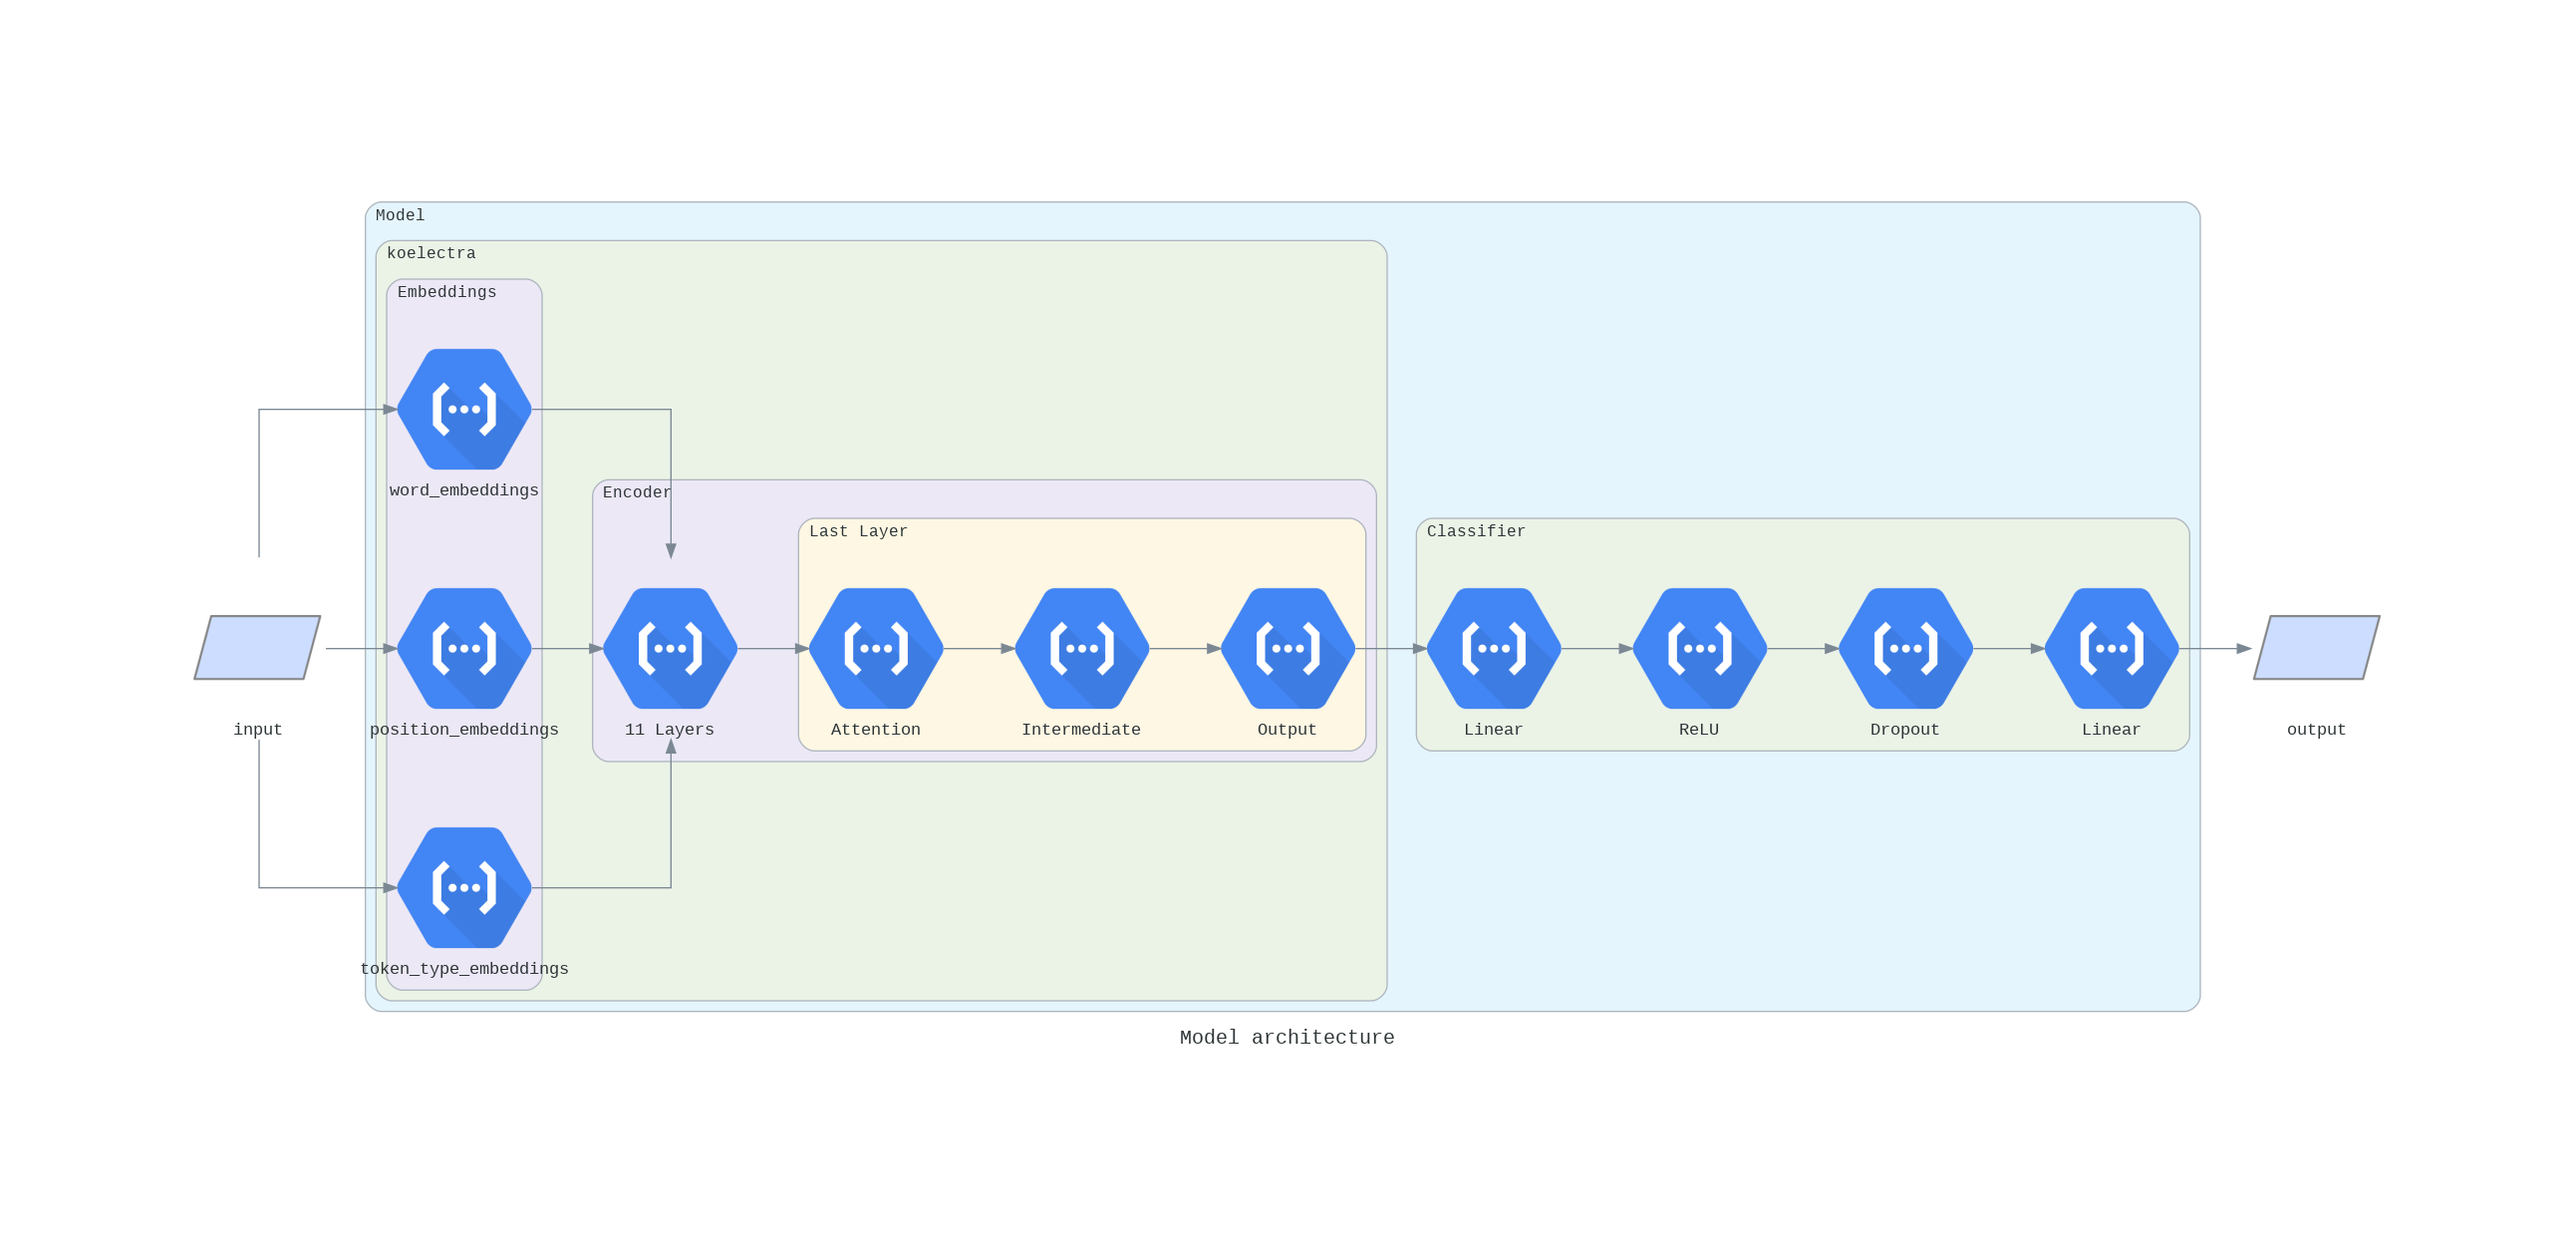

In [20]:
# diagrams example url : https://diagrams.mingrammer.com/docs/getting-started/examples
with Diagram("Model architecture", show=False) as diag:
    input_node = InputOutput('input')
    output_node = InputOutput('output')
    with Cluster("Model"):
        with Cluster("koelectra"):
            with Cluster("Encoder"):
                layers = Functions("11 Layers")
                with Cluster("Last Layer"):
                    attention = Functions("Attention")
                    Intermediate = Functions("Intermediate")
                    Output = Functions("Output")
            with Cluster("Embeddings"):
                input_node >> [Functions("word_embeddings"),Functions("position_embeddings"),Functions("token_type_embeddings")] >> layers >> attention >> Intermediate >> Output

        with Cluster("Classifier"):
            l1 = Functions("Linear")
            relu1 = Functions("ReLU")
            dropout1 = Functions("Dropout")
            l2 = Functions("Linear")
    Output >> l1 >> relu1 >> dropout1 >> l2 >> output_node
display(diag)